# 🌲 Random Forest Classifier - Dự đoán nguy cơ lũ lụt

## Mục tiêu
- Xây dựng mô hình phân loại nguy cơ lũ lụt dựa trên các đặc trưng thời tiết
- Chia dữ liệu theo tỷ lệ **60% Train - 20% Validation - 20% Test**
- Đánh giá mô hình trên cả tập validation và test

## Các bước thực hiện
1. Import thư viện và đọc dữ liệu
2. Tiền xử lý dữ liệu
3. Chia dữ liệu train/validation/test
4. Huấn luyện mô hình Random Forest
5. Đánh giá mô hình
6. Trực quan hóa kết quả
7. Lưu mô hình

---

## 1. Import thư viện

In [10]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import unicodedata
import joblib
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)

# Cấu hình hiển thị
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (10, 6)

print("✅ Đã import các thư viện cần thiết")

✅ Đã import các thư viện cần thiết


---

## 2. Đọc và tiền xử lý dữ liệu

In [2]:
# Đọc dữ liệu
DATA_PATH = 'data_train_classifier.csv'
df = pd.read_csv(DATA_PATH)

print(f"📁 Đã đọc dữ liệu từ: {DATA_PATH}")
print(f"📊 Kích thước dữ liệu: {df.shape[0]} mẫu, {df.shape[1]} cột")

📁 Đã đọc dữ liệu từ: data_train_classifier.csv
📊 Kích thước dữ liệu: 13176 mẫu, 11 cột


### 2.1 Khám phá dữ liệu

In [3]:
# Thông tin tổng quan về dữ liệu
print("=" * 60)
print("📋 THÔNG TIN TỔNG QUAN VỀ DỮ LIỆU")
print("=" * 60)

print("\n📌 Các cột trong dữ liệu:")
print(df.columns.tolist())

print("\n📌 Thông tin chi tiết:")
df.info()

print("\n📌 Thống kê mô tả:")
df.describe()

📋 THÔNG TIN TỔNG QUAN VỀ DỮ LIỆU

📌 Các cột trong dữ liệu:
['soil_humidity', 'temperature', 'air_pressure', 'air_humidity', 'rainfall', 'rain_duration', 'rain_24h', 'rain_48h_avg', 'rain_max_24h', 'rain_acc_week', 'label']

📌 Thông tin chi tiết:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13176 entries, 0 to 13175
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   soil_humidity  13176 non-null  float64
 1   temperature    13176 non-null  float64
 2   air_pressure   13176 non-null  float64
 3   air_humidity   13176 non-null  float64
 4   rainfall       13176 non-null  float64
 5   rain_duration  13176 non-null  int64  
 6   rain_24h       13176 non-null  float64
 7   rain_48h_avg   13176 non-null  float64
 8   rain_max_24h   13176 non-null  float64
 9   rain_acc_week  13176 non-null  float64
 10  label          13176 non-null  object 
dtypes: float64(9), int64(1), object(1)
memory usage: 1.1+ MB

📌 Thống kê

,soil_humidity,temperature,air_pressure,air_humidity,rainfall,rain_duration,rain_24h,rain_48h_avg,rain_max_24h,rain_acc_week
count,13176.000000,13176.000000,13176.000000,13176.000000,13176.000000,13176.000000,13176.000000,13176.000000,13176.000000,13176.000000
mean,42.139613,27.541666,1002.914417,79.025146,0.281475,82.123103,6.697540,0.278608,1.207289,46.466867
std,6.259916,3.660291,5.606977,12.931434,0.851187,107.414103,13.484122,0.473128,1.942628,53.066335
min,26.083672,16.058258,989.438700,32.101513,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,38.891710,25.184174,998.596250,70.257465,0.000000,0.000000,0.132998,0.012270,0.060757,10.720625
50%,43.510434,27.560699,1001.667205,81.276017,0.005262,40.000000,1.299749,0.080856,0.361545,28.412303
75%,47.026922,29.865020,1007.300775,89.726614,0.158711,121.250000,7.222557,0.347512,1.624677,65.564701
max,52.000427,39.192047,1022.491300,99.803050,20.112710,513.000000,127.800051,3.957539,20.112710,367.934295


### 2.2 Xử lý nhãn (Label Encoding)

In [4]:
def normalize_unicode(text: str) -> str:
    """Chuẩn hóa Unicode cho text tiếng Việt."""
    return unicodedata.normalize('NFC', str(text).strip())

def encode_labels(df: pd.DataFrame, label_col: str = 'label') -> pd.DataFrame:
    """
    Mã hóa nhãn phân loại sang dạng số.
    
    Args:
        df: DataFrame chứa dữ liệu
        label_col: Tên cột chứa nhãn
        
    Returns:
        DataFrame với cột nhãn đã được mã hóa
    """
    # Định nghĩa mapping nhãn
    label_mapping = {
        'Bình thường': 0,
        'Cảnh báo': 1,
        'Nguy hiểm': 2
    }
    
    # Chuẩn hóa Unicode cho mapping
    label_mapping = {normalize_unicode(k): v for k, v in label_mapping.items()}
    
    # Chuẩn hóa và mã hóa nhãn
    df[label_col] = df[label_col].apply(normalize_unicode)
    df['label_encoded'] = df[label_col].map(label_mapping)
    
    return df, label_mapping

# Thực hiện mã hóa nhãn
print("📌 Các nhãn gốc:", df['label'].unique())
df, label_mapping = encode_labels(df)
print("📌 Các nhãn sau mã hóa:", df['label_encoded'].unique())
print("📌 Mapping:", label_mapping)

# Kiểm tra phân bố nhãn
print("\n📊 Phân bố nhãn:")
print(df['label'].value_counts())

📌 Các nhãn gốc: ['Cảnh báo' 'Bình thường' 'Nguy hiểm']
📌 Các nhãn sau mã hóa: [1 0 2]
📌 Mapping: {'Bình thường': 0, 'Cảnh báo': 1, 'Nguy hiểm': 2}

📊 Phân bố nhãn:
label
Cảnh báo       6960
Bình thường    5200
Nguy hiểm      1016
Name: count, dtype: int64


## 3. Chuẩn bị dữ liệu huấn luyện

### 3.1 Chọn đặc trưng và nhãn

In [5]:
# Định nghĩa danh sách đặc trưng
FEATURE_COLUMNS = [
    'soil_humidity',      # Độ ẩm đất
    'temperature',        # Nhiệt độ
    'air_pressure',       # Áp suất không khí
    'air_humidity',       # Độ ẩm không khí
    'rainfall',           # Lượng mưa hiện tại
    'rain_duration',      # Thời gian mưa
    'rain_24h',           # Lượng mưa 24h
    'rain_48h_avg',       # Lượng mưa trung bình 48h
    'rain_max_24h',       # Lượng mưa tối đa 24h
    'rain_acc_week'       # Lượng mưa tích lũy tuần
]

# Tách đặc trưng và nhãn
X = df[FEATURE_COLUMNS]
y = df['label_encoded']

print(f"📊 Số lượng đặc trưng: {len(FEATURE_COLUMNS)}")
print(f"📊 Số lượng mẫu: {len(X)}")
print(f"\n📌 Danh sách đặc trưng:")
for i, col in enumerate(FEATURE_COLUMNS, 1):
    print(f"   {i}. {col}")

📊 Số lượng đặc trưng: 10
📊 Số lượng mẫu: 13176

📌 Danh sách đặc trưng:
   1. soil_humidity
   2. temperature
   3. air_pressure
   4. air_humidity
   5. rainfall
   6. rain_duration
   7. rain_24h
   8. rain_48h_avg
   9. rain_max_24h
   10. rain_acc_week


### 3.2 Chia dữ liệu Train/Validation/Test (60:20:20)

In [7]:
# Chia dữ liệu: 60% Train, 20% Validation, 20% Test
# Bước 1: Tách 60% train và 40% còn lại
RANDOM_STATE = 42  # Đặt hạt giống ngẫu nhiên để tái lập kết quả
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.4,  # 40% cho validation + test
    random_state=RANDOM_STATE,
    stratify=y  # Đảm bảo phân bố nhãn đồng đều
)

# Bước 2: Chia 40% còn lại thành 50-50 (tức 20-20 so với tổng)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=0.5,  # 50% của 40% = 20% tổng
    random_state=RANDOM_STATE,
    stratify=y_temp
)

# Hiển thị thông tin phân chia
print("=" * 60)
print("📊 THÔNG TIN PHÂN CHIA DỮ LIỆU (60:20:20)")
print("=" * 60)
print(f"\n🔹 Tập huấn luyện (Train):    {len(X_train):>6} mẫu ({len(X_train)/len(X)*100:.1f}%)")
print(f"🔹 Tập kiểm thử (Validation): {len(X_val):>6} mẫu ({len(X_val)/len(X)*100:.1f}%)")
print(f"🔹 Tập test (Test):           {len(X_test):>6} mẫu ({len(X_test)/len(X)*100:.1f}%)")
print(f"{'─' * 60}")
print(f"🔹 Tổng cộng:                 {len(X):>6} mẫu")

# Kiểm tra phân bố nhãn trong từng tập
print("\n📈 Phân bố nhãn trong từng tập:")
for name, y_set in [("Train", y_train), ("Validation", y_val), ("Test", y_test)]:
    counts = y_set.value_counts().sort_index()
    print(f"\n   {name}:")
    for label, count in counts.items():
        label_name = [k for k, v in label_mapping.items() if v == label][0]
        print(f"      - {label_name}: {count} ({count/len(y_set)*100:.1f}%)")

📊 THÔNG TIN PHÂN CHIA DỮ LIỆU (60:20:20)

🔹 Tập huấn luyện (Train):      7905 mẫu (60.0%)
🔹 Tập kiểm thử (Validation):   2635 mẫu (20.0%)
🔹 Tập test (Test):             2636 mẫu (20.0%)
────────────────────────────────────────────────────────────
🔹 Tổng cộng:                  13176 mẫu

📈 Phân bố nhãn trong từng tập:

   Train:
      - Bình thường: 3120 (39.5%)
      - Cảnh báo: 4176 (52.8%)
      - Nguy hiểm: 609 (7.7%)

   Validation:
      - Bình thường: 1040 (39.5%)
      - Cảnh báo: 1392 (52.8%)
      - Nguy hiểm: 203 (7.7%)

   Test:
      - Bình thường: 1040 (39.5%)
      - Cảnh báo: 1392 (52.8%)
      - Nguy hiểm: 204 (7.7%)


## 4. Huấn luyện mô hình Random Forest

### 4.1 Cấu hình và huấn luyện mô hình

In [11]:
# Cấu hình mô hình Random Forest
model_config = {
    'n_estimators': 100,          # Số lượng cây quyết định
    'class_weight': 'balanced',   # Cân bằng trọng số theo nhãn
    'random_state': RANDOM_STATE,
    'min_samples_split': 2,       # Số mẫu tối thiểu để chia nút
    'min_samples_leaf': 1,        # Số mẫu tối thiểu tại lá
    'n_jobs': -1,                 # Sử dụng tất cả CPU cores
    'verbose': 0
}

print("=" * 60)
print("🌲 CẤU HÌNH MÔ HÌNH RANDOM FOREST")
print("=" * 60)
for key, value in model_config.items():
    print(f"   • {key}: {value}")

# Khởi tạo mô hình
clf = RandomForestClassifier(**model_config)

# Huấn luyện mô hình
print("\n⏳ Đang huấn luyện mô hình...")
start_time = time.time()
clf.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"✅ Hoàn thành huấn luyện trong {training_time:.2f} giây")

🌲 CẤU HÌNH MÔ HÌNH RANDOM FOREST
   • n_estimators: 100
   • class_weight: balanced
   • random_state: 42
   • min_samples_split: 2
   • min_samples_leaf: 1
   • n_jobs: -1
   • verbose: 0

⏳ Đang huấn luyện mô hình...
✅ Hoàn thành huấn luyện trong 0.96 giây
✅ Hoàn thành huấn luyện trong 0.96 giây


### 4.2 Đánh giá mô hình trên các tập dữ liệu

In [ ]:
def evaluate_model(model, X, y, set_name: str) -> dict:
    """
    Đánh giá mô hình trên một tập dữ liệu.
    
    Args:
        model: Mô hình đã huấn luyện
        X: Đặc trưng
        y: Nhãn thực tế
        set_name: Tên tập dữ liệu
        
    Returns:
        Dictionary chứa các metrics
    """
    y_pred = model.predict(X)
    
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y, y_pred, average='weighted', zero_division=0)
    
    return {
        'set_name': set_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'y_pred': y_pred
    }

# Đánh giá trên cả 3 tập
print("=" * 70)
print("📊 KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH TRÊN CÁC TẬP TRAIN VÀ VALIDATION")
print("=" * 70)

results = {}
for name, X_set, y_set in [
    ("Train", X_train, y_train),
    ("Validation", X_val, y_val),
]:
    results[name] = evaluate_model(clf, X_set, y_set, name)

# Hiển thị kết quả dạng bảng
print(f"\n{'Tập dữ liệu':<15} {'Accuracy':>12} {'Precision':>12} {'Recall':>12} {'F1-Score':>12}")
print("-" * 70)
for name, metrics in results.items():
    print(f"{name:<15} {metrics['accuracy']*100:>11.2f}% {metrics['precision']*100:>11.2f}% "
          f"{metrics['recall']*100:>11.2f}% {metrics['f1_score']*100:>11.2f}%")
print("-" * 70)

# Cảnh báo overfitting
train_acc = results['Train']['accuracy']
val_acc = results['Validation']['accuracy']
if train_acc - val_acc > 0.1:
    print("\n⚠️  Cảnh báo: Có dấu hiệu overfitting (Train accuracy cao hơn Validation nhiều)")
else:
    print("\n✅ Mô hình không có dấu hiệu overfitting nghiêm trọng")

📊 KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH TRÊN CÁC TẬP TRAIN VÀ VALIDATION

Tập dữ liệu         Accuracy    Precision       Recall     F1-Score
----------------------------------------------------------------------
Train                100.00%      100.00%      100.00%      100.00%
Validation            97.91%       97.92%       97.91%       97.91%
Test                  97.57%       97.58%       97.57%       97.57%
----------------------------------------------------------------------

✅ Mô hình không có dấu hiệu overfitting nghiêm trọng


### 4.3 Báo cáo chi tiết trên tập Validation

In [15]:
# Báo cáo chi tiết trên tập Validation
y_val_pred = results['Validation']['y_pred']
target_names = ['Bình thường', 'Cảnh báo', 'Nguy hiểm']

print("=" * 70)
print("📋 BÁO CÁO CHI TIẾT - TẬP VALIDATION")
print("=" * 70)

print("\n📊 Confusion Matrix:")
cm_val = confusion_matrix(y_val, y_val_pred)
print(cm_val)

print("\n📄 Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=target_names, zero_division=0))

📋 BÁO CÁO CHI TIẾT - TẬP VALIDATION

📊 Confusion Matrix:
[[1017   23    0]
 [  17 1372    3]
 [   0   12  191]]

📄 Classification Report:
              precision    recall  f1-score   support

 Bình thường       0.98      0.98      0.98      1040
    Cảnh báo       0.98      0.99      0.98      1392
   Nguy hiểm       0.98      0.94      0.96       203

    accuracy                           0.98      2635
   macro avg       0.98      0.97      0.97      2635
weighted avg       0.98      0.98      0.98      2635



### 4.4 Báo cáo chi tiết trên tập Test

In [18]:
# Đánh giá trên cả 3 tập
print("=" * 70)
print("📊 KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH TRÊN TẬP TEST")
print("=" * 70)

results = {}
for name, X_set, y_set in [
    ("Test", X_test, y_test)
]:
    results[name] = evaluate_model(clf, X_set, y_set, name)

# Hiển thị kết quả dạng bảng
print(f"\n{'Tập dữ liệu':<15} {'Accuracy':>12} {'Precision':>12} {'Recall':>12} {'F1-Score':>12}")
print("-" * 70)
for name, metrics in results.items():
    print(f"{name:<15} {metrics['accuracy']*100:>11.2f}% {metrics['precision']*100:>11.2f}% "
          f"{metrics['recall']*100:>11.2f}% {metrics['f1_score']*100:>11.2f}%")
print("-" * 70)


📊 KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH TRÊN TẬP TEST

Tập dữ liệu         Accuracy    Precision       Recall     F1-Score
----------------------------------------------------------------------
Test                  97.57%       97.58%       97.57%       97.57%
----------------------------------------------------------------------


In [25]:
# Báo cáo chi tiết trên tập Test
y_test_pred = results['Test']['y_pred']

print("=" * 70)
print("📋 BÁO CÁO CHI TIẾT - TẬP TEST")
print("=" * 70)

print("\n📊 Confusion Matrix:")
cm_test = confusion_matrix(y_test, y_test_pred)
print(cm_test)

print("\n📄 Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=target_names, zero_division=0))

📋 BÁO CÁO CHI TIẾT - TẬP TEST

📊 Confusion Matrix:
[[1011   29    0]
 [  11 1373    8]
 [   0   16  188]]

📄 Classification Report:
              precision    recall  f1-score   support

 Bình thường       0.99      0.97      0.98      1040
    Cảnh báo       0.97      0.99      0.98      1392
   Nguy hiểm       0.96      0.92      0.94       204

    accuracy                           0.98      2636
   macro avg       0.97      0.96      0.97      2636
weighted avg       0.98      0.98      0.98      2636



## 5. Lưu mô hình

In [23]:
# Lưu mô hình
MODEL_PATH = 'model_classifier.pkl'

print("=" * 60)
print("💾 LƯU MÔ HÌNH")
print("=" * 60)

# Lưu mô hình với metadata
model_data = {
    'model': clf,
    'feature_columns': FEATURE_COLUMNS,
    'label_mapping': label_mapping,
    'training_info': {
        'train_accuracy': results['Train']['accuracy'],
        'val_accuracy': results['Validation']['accuracy'],
        'test_accuracy': results['Test']['accuracy'],
        'training_time': training_time,
        'n_train_samples': len(X_train),
        'n_val_samples': len(X_val),
        'n_test_samples': len(X_test)
    }
}

joblib.dump(model_data, MODEL_PATH)
print(f"\n✅ Đã lưu mô hình vào: {MODEL_PATH}")
print(f"📁 Kích thước file: {os.path.getsize(MODEL_PATH) / 1024:.2f} KB")

💾 LƯU MÔ HÌNH

✅ Đã lưu mô hình vào: model_classifier.pkl
📁 Kích thước file: 4478.21 KB


## 6. Trực quan hóa kết quả

### 6.1 So sánh độ chính xác các tập dữ liệu

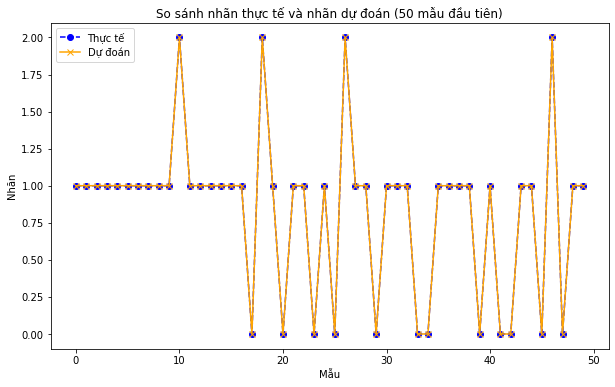

In [27]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ so sánh thực tế và dự đoán
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:50], label="Thực tế", marker='o', linestyle='--', color='blue')
plt.plot(y_test_pred[:50], label="Dự đoán", marker='x', linestyle='-', color='orange')
plt.title("So sánh nhãn thực tế và nhãn dự đoán (50 mẫu đầu tiên)")
plt.xlabel("Mẫu")
plt.ylabel("Nhãn")
plt.legend()
plt.show()

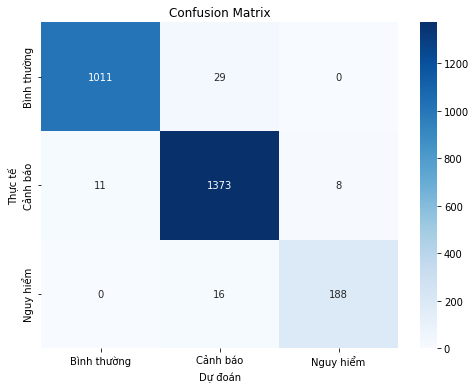

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Tính Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

# Vẽ heatmap cho Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Bình thường', 'Cảnh báo', 'Nguy hiểm'], yticklabels=['Bình thường', 'Cảnh báo', 'Nguy hiểm'])
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.title("Confusion Matrix")
plt.show()